In [1]:
import numpy as np
from PIL import Image
import networkx as nx
import matplotlib.pyplot as plt


Skeleton px=6322
Adding 13/24 dense nodes to existing 307 nodes.
Extracted street network:
  - 152 nodes
  - 366 edges
(512, 512)
graph nodes: 152
graph edges: 366


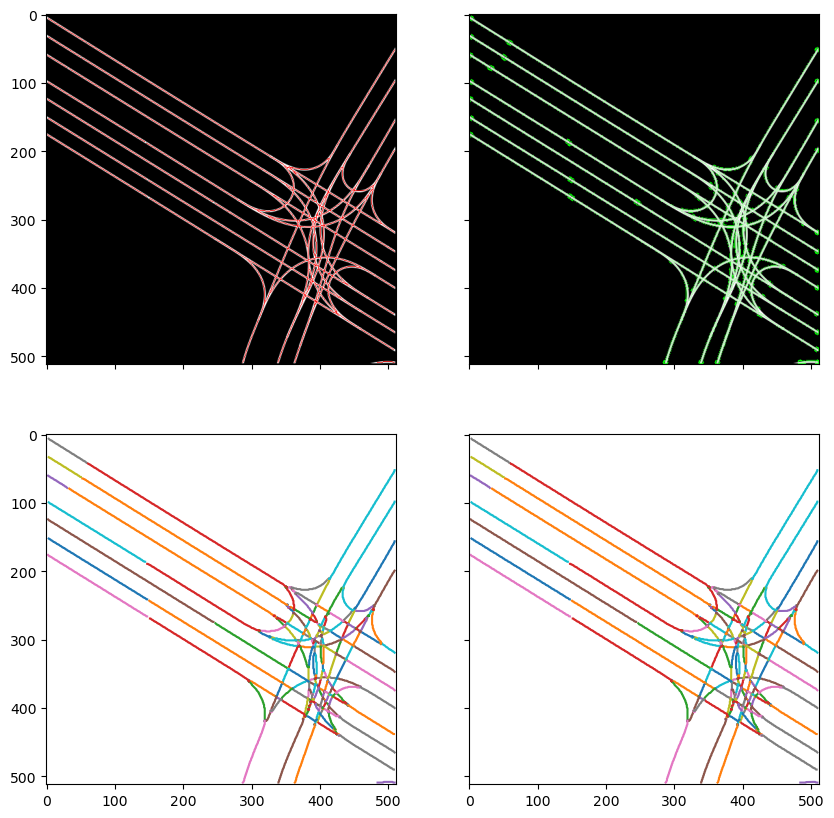

In [4]:
from cubic_spline import CubicSpline2D
from extract_network import find_color, extract_network, render_skeleton, render_network

# def generate_frenet_frame(centerline_pts: np.ndarray):
def generate_frenet_frame(xs: np.ndarray, ys: np.ndarray):
    cubic_spline = CubicSpline2D(xs, ys)
    s = np.arange(0, cubic_spline.s[-1], 0.1)
    # s = np.linspace(0, cubic_spline.s[-1], xs.shape[0])
    ref_xy = [cubic_spline.calc_position(i_s) for i_s in s]
    ref_yaw = [cubic_spline.calc_yaw(i_s) for i_s in s]
    ref_rk = [cubic_spline.calc_curvature(i_s) for i_s in s]
    return cubic_spline, np.column_stack((ref_xy, ref_yaw, ref_rk))

def image_to_polylines(im: Image, simplify: bool=True) -> np.ndarray:
    rgb = (255, 255, 255)
    px = find_color(im, rgb).T
    skel, g = extract_network(px, min_distance=4, simplify=simplify)

    fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
    axes = axes.ravel()
    
    def network_to_polylines(g: nx.Graph, simplify: bool=True) -> list:
        for i, (n1, n2, k) in enumerate(g.edges(keys=True)):
            edge = g[n1][n2][k]
            path = edge['path']
            if simplify:
                coords = np.array(path.coords)
            else:
                coords = np.array(path)
            yield coords

    polylines = network_to_polylines(g, simplify=simplify)

    for polyline in polylines:
        xs = polyline[:, 0]
        ys = polyline[:, 1]
        axes[2].plot(xs, ys)

        cubic_spline, ref_curve = generate_frenet_frame(xs, ys)
        axes[3].plot(ref_curve[:, 0], ref_curve[:, 1])

    img_skeleton = render_skeleton(im, skel, (255, 0, 0))
    img_network = render_network(im, g, (0, 255, 0))
    axes[0].imshow(img_skeleton)
    axes[1].imshow(img_network)
    axes[2].set_aspect('equal')
    axes[2].invert_yaxis()
    axes[3].set_aspect('equal')
    axes[3].invert_yaxis()
    # plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    # plt.margins(0, 0)
    plt.show()

    return polylines

img_id = 1
png_file = f'samples/gt/{img_id}_gray.png'
im = Image.open(png_file)
# polylines = image_to_polylines(im, simplify=True)
polylines = image_to_polylines(im, simplify=False)

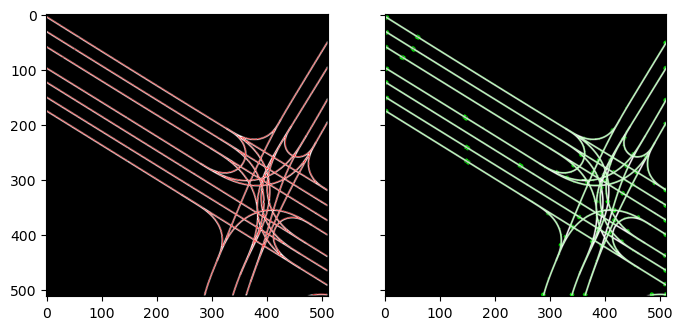

In [4]:
degrees = [val for (node, val) in G.degree()]


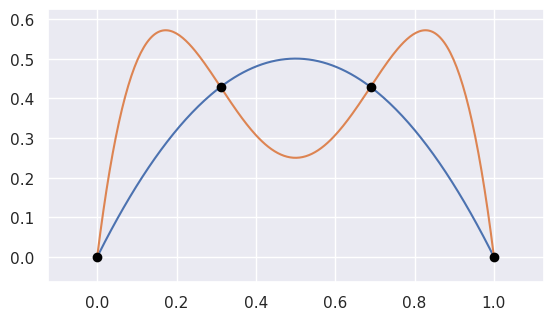

In [7]:
import bezier
import seaborn
import numpy as np

nodes1 = np.asfortranarray([
    [0.0, 0.5, 1.0],
    [0.0, 1.0, 0.0],
])
curve1 = bezier.Curve(nodes1, degree=2)

nodes2 = np.asfortranarray([
    [0.0, 0.25,  0.5, 0.75, 1.0],
    [0.0, 2.0 , -2.0, 2.0 , 0.0],
])
curve2 = bezier.Curve.from_nodes(nodes2)
intersections = curve1.intersect(curve2)

s_vals = np.asfortranarray(intersections[0, :])
points = curve1.evaluate_multi(s_vals)

seaborn.set()
ax = curve1.plot(num_pts=256)
_ = curve2.plot(num_pts=256, ax=ax)
lines = ax.plot(
    points[0, :], points[1, :],
    marker="o", linestyle="None", color="black")
_ = ax.axis("scaled")
_ = ax.set_xlim(-0.125, 1.125)
_ = ax.set_ylim(-0.0625, 0.625)